In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import warnings
import pickle
warnings.filterwarnings("ignore")


In [2]:
# Import data from 'Data/O3 development.xlsx'
thickness_lst = []
wtw_thickness = []
refractive_lst = []
wtw_refractive = []
f = pd.ExcelFile('Data/O3 development.xlsx')

for name in f.sheet_names:
    if name == 'DOE':
        doe = pd.read_excel('Data/O3 development.xlsx', engine='openpyxl',sheet_name = 'DOE')
        doe = doe[doe.columns[-6::]]
        doe.columns = [['Ar (sccm)', 'O3 (sccm)', 'Turn on (s) TMA', 'Turn off (s) TMA','Turn off (s) Ozone','Turn off (s) Ozone']]
        doe = doe[1:]
        doe.index = ['Run{}'.format(x) for x in range(15,23)]
    else:
        cur_sheet = pd.read_excel('Data/O3 development.xlsx', engine='openpyxl',sheet_name = name)
        needed_cols = ['Unnamed: {}'.format(x) for x in range(2,13)]
        thickness = cur_sheet[needed_cols][2:26].reset_index(drop = True)
        thickness.columns = ['SE testing point:{}'.format(x) for x in range(1, 10)]+['Avg', 'WIW']
        thickness_lst.append(thickness)
        
        refractive = cur_sheet[needed_cols][30::].reset_index(drop = True)
        refractive.columns = ['SE testing point:{}'.format(x) for x in range(1, 10)] + ['Avg','WIW']
        refractive_lst.append(refractive)
        
        wtw_thickness.append(cur_sheet['Unnamed: 13'].iloc[2])
        wtw_refractive.append(cur_sheet['Unnamed: 13'].iloc[30])

In [3]:
para = doe.to_numpy()
# rf = np.array(refractive_lst)
rf_wtw = np.array(wtw_refractive)
# tk = np.array(thickness_lst)
tk_wtw = np.array(wtw_thickness)

In [4]:
# choices of length scale upperbound and kernels as a list
length_scale_choices = [1000,100,10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
length_scale_choices.reverse()
res = []
NOISE_LEVEL = 1e-5
def produce_kernels_scale(upperbounds,res):
    # upperbounds: a list of float denoting the upperbounds for length scales of kernels (also sigma_0_bounds for dotproduct kernel)
    # res: a list of kernel outputs
    for i in upperbounds:
        
        kernel_choices = [1.0 * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 1.0 * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL)+C(),
                 1.0 * Matern(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 1.0 * RationalQuadratic(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 C() * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 DotProduct(sigma_0_bounds=(0,i))+WhiteKernel(noise_level=NOISE_LEVEL)]

        res.extend(kernel_choices)
    return res

kernel_choices = produce_kernels_scale(length_scale_choices,res)

Default Setup:


- NUM_OF_DATA_POINTS = 20

- NUM_OF_PLOT_POINTS = 100

- NOISE_LEVEL = 1e-5

- kernel = 1.0 * RBF(length_scale=5) + WhiteKernel(noise_level=NOISE_LEVEL)

- gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

- scoring = "neg_mean_squared_error"

In [5]:
# rename and reshape training data and labels
X = para 
Y = np.array([tk_wtw,rf_wtw]).reshape(8,2)

In [6]:
#### Kernel setting and prediction
#### Taking out one data point and training on the rest, generating len(Y) different models
def model_performance(kernel,X,Y,txt):
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)
    models = cross_validate(gp, X, Y, return_estimator = True,cv=len(Y),scoring="neg_mean_squared_error",return_train_score = True)
    for i in models["estimator"]:
        txt.write(f"Learned kernel: {i.kernel_}\n")
    txt.write(f"\ntest scores for each model: {models['test_score']} \n\n")
    txt.write(f"negative mean squared error: {models['train_score']} \n\n")
    txt.write(f"log marginal likelihood: {[i.log_marginal_likelihood() for i in models['estimator']]} \n\n")
    return models

## writing to txt file
with open("o3_models_out.txt", "w") as text_file:
    for i in kernel_choices:
        text_file.write(f'### Current kernel: {i} ###\n\n')
        models = model_performance(i,X,Y,text_file)
        text_file.write("----------current kernel finished processing----------\n\n")

In [7]:
#### Exhaustive grid search 
param_space = {'alpha':np.logspace(-7,-2,6), 
               'kernel':kernel_choices}
gp = GaussianProcessRegressor()
gp_search = GridSearchCV(gp, param_space,
                         scoring={"mean_squared_error": make_scorer(mean_squared_error,greater_is_better=False),
                                  "log_marginal_likelihood":lambda estimator, X, Y: estimator.log_marginal_likelihood_value_}
                                                  ,cv=len(Y),return_train_score=True,refit="mean_squared_error")
gp_search.fit(X, Y)


GridSearchCV(cv=8, estimator=GaussianProcessRegressor(),
             param_grid={'alpha': array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02]),
                         'kernel': [1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
                                    1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05) + 1**2,
                                    1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-05),
                                    1**2 * RationalQuadratic(alpha=1,...
                                    1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-05),
                                    1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
                                    DotProduct(sigma_0=1) + WhiteKernel(noise_level=1e-05), ...]},
             refit='mean_squared_error', return_train_score=True,
             scoring={'log_marginal_likelihood': <function <lambda> at 0x000001D53757216

In [8]:
res = pd.DataFrame(gp_search.cv_results_)
col_reorder_select = ['param_kernel',
                      'mean_train_log_marginal_likelihood','mean_train_mean_squared_error',
                      'mean_test_log_marginal_likelihood','mean_test_mean_squared_error', 
                      'param_alpha', 'params',
                       'std_train_mean_squared_error','std_test_log_marginal_likelihood',
                      'std_test_mean_squared_error','rank_test_mean_squared_error',
                      'rank_test_log_marginal_likelihood',
       'split0_test_mean_squared_error', 'split1_test_mean_squared_error',
       'split2_test_mean_squared_error', 'split3_test_mean_squared_error',
       'split4_test_mean_squared_error', 'split5_test_mean_squared_error',
       'split6_test_mean_squared_error', 'split7_test_mean_squared_error',
       'split0_train_mean_squared_error',
       'split1_train_mean_squared_error', 'split2_train_mean_squared_error',
       'split3_train_mean_squared_error', 'split4_train_mean_squared_error',
       'split5_train_mean_squared_error', 'split6_train_mean_squared_error',
       'split7_train_mean_squared_error',
       'split0_test_log_marginal_likelihood',
       'split1_test_log_marginal_likelihood',
       'split2_test_log_marginal_likelihood',
       'split3_test_log_marginal_likelihood',
       'split4_test_log_marginal_likelihood',
       'split5_test_log_marginal_likelihood',
       'split6_test_log_marginal_likelihood',
       'split7_test_log_marginal_likelihood',
       'split0_train_log_marginal_likelihood',
       'split1_train_log_marginal_likelihood',
       'split2_train_log_marginal_likelihood',
       'split3_train_log_marginal_likelihood',
       'split4_train_log_marginal_likelihood',
       'split5_train_log_marginal_likelihood',
       'split6_train_log_marginal_likelihood',
       'split7_train_log_marginal_likelihood'
       ]
res = res[col_reorder_select]
res.sort_values(by=["mean_train_log_marginal_likelihood",'mean_test_log_marginal_likelihood',
                    'mean_train_mean_squared_error','mean_test_mean_squared_error']
                    ,ascending=False,inplace=True)
res.to_csv("grid_search_o3.csv")

In [9]:
res.head(10)

,param_kernel,mean_train_log_marginal_likelihood,mean_train_mean_squared_error,mean_test_log_marginal_likelihood,mean_test_mean_squared_error,param_alpha,params,std_train_mean_squared_error,std_test_log_marginal_likelihood,std_test_mean_squared_error,...,split6_test_log_marginal_likelihood,split7_test_log_marginal_likelihood,split0_train_log_marginal_likelihood,split1_train_log_marginal_likelihood,split2_train_log_marginal_likelihood,split3_train_log_marginal_likelihood,split4_train_log_marginal_likelihood,split5_train_log_marginal_likelihood,split6_train_log_marginal_likelihood,split7_train_log_marginal_likelihood
63,"1**2 * RationalQuadratic(alpha=1, length_scale...",39.444119,-0.000008,39.444119,-0.000143,0.0,"{'alpha': 1e-07, 'kernel': 1**2 * RationalQuad...",0.000003,1.960306,0.000186,...,37.367022,37.420288,42.608993,41.003543,40.908260,40.749379,38.122627,37.372844,37.367022,37.420288
129,"1**2 * RationalQuadratic(alpha=1, length_scale...",39.426822,-0.000008,39.426822,-0.000143,0.000001,"{'alpha': 1e-06, 'kernel': 1**2 * RationalQuad...",0.000003,1.948283,0.000186,...,37.367022,37.420288,42.608993,41.003543,40.839454,40.679805,38.122627,37.372844,37.367022,37.420288
62,"1**2 * Matern(length_scale=1, nu=1.5) + WhiteK...",39.239385,-0.000009,39.239385,-0.000155,0.0,"{'alpha': 1e-07, 'kernel': 1**2 * Matern(lengt...",0.000003,1.881675,0.000220,...,37.236393,37.286906,42.307182,40.586584,40.688226,40.546924,38.015681,37.247178,37.236393,37.286906
128,"1**2 * Matern(length_scale=1, nu=1.5) + WhiteK...",39.224775,-0.000009,39.224775,-0.000155,0.000001,"{'alpha': 1e-06, 'kernel': 1**2 * Matern(lengt...",0.000003,1.871110,0.000220,...,37.236393,37.286906,42.307182,40.586584,40.629254,40.489019,38.015681,37.247178,37.236393,37.286906
195,"1**2 * RationalQuadratic(alpha=1, length_scale...",39.216346,-0.000008,39.216346,-0.000143,0.00001,"{'alpha': 1e-05, 'kernel': 1**2 * RationalQuad...",0.000003,1.833758,0.000186,...,37.367022,37.420288,42.593713,40.988504,40.024330,39.861587,38.102481,37.372844,37.367022,37.420288
61,1**2 * RBF(length_scale=1) + WhiteKernel(noise...,39.159982,-0.000009,39.159982,-0.000140,0.0,"{'alpha': 1e-07, 'kernel': 1**2 * RBF(length_s...",0.000004,2.130369,0.000181,...,36.885633,36.931183,42.614705,41.020121,40.628537,40.472503,37.832042,36.895128,36.885633,36.931183
127,1**2 * RBF(length_scale=1) + WhiteKernel(noise...,39.142639,-0.000009,39.142639,-0.000140,0.000001,"{'alpha': 1e-06, 'kernel': 1**2 * RBF(length_s...",0.000004,2.119237,0.000181,...,36.885633,36.931183,42.614705,41.020121,40.559665,40.402631,37.832042,36.895128,36.885633,36.931183
60,1**2 * RBF(length_scale=1) + WhiteKernel(noise...,38.992450,-0.000010,38.992450,-0.000143,0.0,"{'alpha': 1e-07, 'kernel': 1**2 * RBF(length_s...",0.000004,2.107815,0.000186,...,36.824703,36.866966,42.608994,41.003545,40.190900,40.038986,37.566638,36.838869,36.824703,36.866966
64,1**2 * RBF(length_scale=1) + WhiteKernel(noise...,38.992450,-0.000010,38.992450,-0.000143,0.0,"{'alpha': 1e-07, 'kernel': 1**2 * RBF(length_s...",0.000004,2.107815,0.000186,...,36.824703,36.866966,42.608994,41.003545,40.190900,40.038986,37.566638,36.838869,36.824703,36.866966
126,1**2 * RBF(length_scale=1) + WhiteKernel(noise...,38.979035,-0.000010,38.979035,-0.000143,0.000001,"{'alpha': 1e-06, 'kernel': 1**2 * RBF(length_s...",0.000004,2.100760,0.000186,...,36.824703,36.866966,42.608994,41.003545,40.134187,39.988380,37.566638,36.838869,36.824703,36.866966


↓Plot for a list of estimators. Using dotproduct kernels for the moment. 

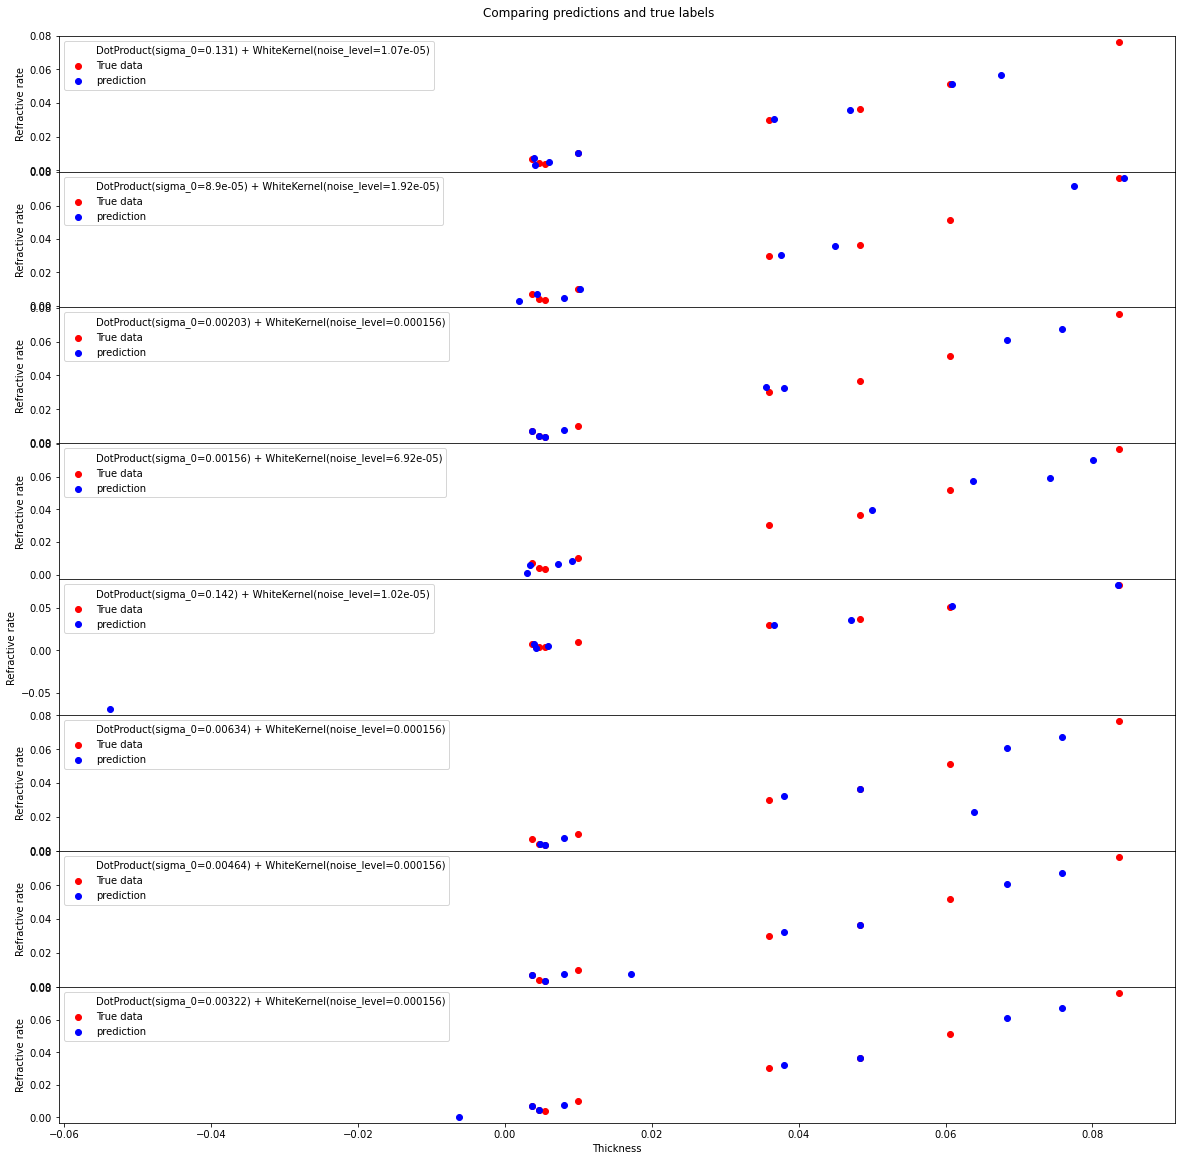

In [10]:
show_plot = True
num_models = len(models["estimator"])
if show_plot:
    fig = plt.figure(figsize=(20,20))
    gs = fig.add_gridspec(len(Y), hspace=0)
    axs = gs.subplots(sharex=True)
    fig.suptitle('Comparing predictions and true labels',y=0.9)
    for estimator, i in zip(models["estimator"],range(num_models)):
        axs[i].scatter(Y[:,0], Y[:,1],label="True data",color="r")
        prediction = estimator.predict(X)
        w = prediction[:,0]
        n = prediction[:,1]
        axs[i].scatter(w,n,label="prediction",color="b")
        axs[i].plot([], [], ' ', label=estimator.kernel_)
        axs[i].legend(loc="upper left")
        axs[i].set_ylabel("Refractive rate")
        
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    plt.xlabel("Thickness")
    plt.savefig('o3.jpeg',format='jpeg')